---
# Modelling hippocampal neurons of animals <br> navigating in VR with recurrent neural networks
### Marco P. Abrate, Daniel Liu &emsp;&emsp;&emsp;&emsp;&emsp;&emsp; University College London (UCL)
---

#### Outline
**Part 1: Rat simulation in 3D**
- Motion model with `RatInABox`

- Environment design

- Simulated rat vision with `ratvision`

**Part 2: Vision autoencoder**

**Part 3: Hippocampus model with RNN**

**Part 4: Hidden state representations analysis**
- Rate maps

- Polar maps

- Quantitive metrics

- Comparison with *in vivo* recordings

---
## **Part 4: Hidden state representations analysis**
In this notebook, we will write code to extract representations from the **RNN hidden states**. These includes:
- Rate maps
- Polar maps
- Quantitative metrics
- Comparison with _in vivo_ data

Before starting this notebook, make sure you have:
- trajectory data from part 1, including speed and rotational speed
- embedded vision data from the Vision Autoencoder we trained in part 2
- RNN model of the hippocampus we trained in part 3


### 0. Install and import dependencies

In [1]:
!pip install torch torchvision torchaudio
!pip install numpy
!pip install matplotlib
!pip install scipy

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
    
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

### 1. Load evaluation data and trained RNN

As a first step, we will import the definitions of the RNN we coded in part 3, and load the trained weights. We will also load the embeddings of the data we will use to evaluate the hidden state representations, and some auxiliary variables that we will use to compute the rate maps.

In [3]:
from utils import create_multiple_subsampling, SensoryDataset, PredictiveRNN

In [4]:
# let's load the test data and process it into a dataloader, just like we did in the last part.

STRIDE = 10
d = '../data/adult'
trial_paths = sorted([p for p in Path(d).iterdir() if 'exp' in p.name])

repr_embeddings = []
repr_vel, repr_rotvel, repr_pos, repr_hds = [], [], [], []

for idx in range(20, len(trial_paths)):
    tp = trial_paths[idx]
    repr_embeddings.append(
        create_multiple_subsampling(np.load(tp / 'vision_embeddings.npy'), stride=STRIDE)
    )
    repr_vel.append(
        create_multiple_subsampling(
            np.load(tp / 'riab_simulation' / 'velocities.npy'), stride=STRIDE, is_velocity=True
        )
    )
    repr_rotvel.append(
        create_multiple_subsampling(
            np.load(tp / 'riab_simulation' / 'rot_velocities.npy')[..., None],
            stride=STRIDE, is_velocity=True
        )
    )
    repr_pos.append(
        create_multiple_subsampling(np.load(tp / 'riab_simulation' / 'positions.npy'), stride=STRIDE)
    )
    repr_hds.append(
        create_multiple_subsampling(np.load(tp / 'riab_simulation' / 'thetas.npy')[..., None], stride=STRIDE)
    )

repr_embeddings = np.concatenate(repr_embeddings, axis=0)
repr_vel = np.concatenate(repr_vel, axis=0)
repr_rotvel = np.concatenate(repr_rotvel, axis=0)
repr_pos = np.concatenate(repr_pos, axis=0)
repr_hds = np.concatenate(repr_hds, axis=0)

dataloader = torch.utils.data.DataLoader(
    SensoryDataset(
        repr_embeddings, repr_vel, repr_rotvel, repr_pos, repr_hds
    ), shuffle=False
)

Let's re-define the PredictiveRNN model, just like we did in the last part, and load the trained weights.

In [5]:
N_HIDDEN = 500

visual_embedding_dim = repr_embeddings.shape[-1]
motion_signal_dim = repr_vel.shape[-1] + repr_rotvel.shape[-1]
trained_rnn_weights = '../part3/rnn.pth'

rnn = PredictiveRNN(
    DEVICE,
    n_inputs = visual_embedding_dim + motion_signal_dim,
    n_hidden = N_HIDDEN,
    n_outputs = visual_embedding_dim
)

loss_fn = torch.nn.L1Loss()

# load the trained weights
rnn.load_state_dict(torch.load(trained_rnn_weights, weights_only=True))
rnn = rnn.to(DEVICE)

### 2. Get hidden states from trained RNN

In the previous part, we wrote a function named `evaluate_rnn()` that &mdash; when the parameter `for_ratemaps` is set to `True` &mdash; will return a dictionary containing the hidden staes, positions, head directions, velocities, etc. at each time-step for convenience of our analysis.

In [6]:
from utils import evaluate_rnn

d = evaluate_rnn(DEVICE, rnn, dataloader, loss_fn, for_ratemaps=True)

hidden_states = d['hidden_states']
positions = d['positions']
head_directions = d['head_directions']

# Reshape the hidden states, positions, and head directions to
# flatten out the number of trials dimension and keep (timesteps, features)
hidden_states = hidden_states.reshape(-1, hidden_states.shape[-1])
positions = positions.reshape(-1, positions.shape[-1])
head_directions = head_directions.reshape(-1, head_directions.shape[-1])

print(
    'RNN loss (check it does not deviate too much from previous part figure):',
    np.round(np.mean(d['batch_losses']), 2)
)
print(
    'Hidden state, positions, and head directions shapes:\n',
    hidden_states.shape, positions.shape, head_directions.shape
)

RNN loss (check it does not deviate too much from previous part figure): 0.1
Hidden state, positions, and head directions shapes:
 (42660, 500) (42660, 2) (42660, 1)


### 3. Rate maps

The **rate map** of a neuron is the two-dimensional representation of firing rates (or activity in our case) across spatial locations. In the real brain, neuron firings are stochastic. This means there is a lot of noise in the process, and the average activity of each bin is a crude (but unbiased) estimate of the real tuning curve, depending on the amount of data provided. The use of rate maps is standard practice in neuroscience for analysing place cell recordings [27].

We divide the arena into a 25x25 grid (625 bins) and calculate the rate map R for each unit k by averaging unit activity within each spatial bin:

$$
    R_{i,j}^{(k)} = \frac{\sum_t A_t^{(k)} \cdot\overrightarrow{1}_{\mathbf{p}_t \in \text{Bin}_{(i,j)}}}{\sum_t \overrightarrow{1}_{\mathbf{p}_t \in \text{Bin}_{(i,j)}}}\quad i, j \in \{1, \dots, B_p\}\times \{1, \dots, B_p\}
$$

where $A^{(k)}$ is the activity of hidden unit $k$, $\mathbf{p}$ is the agent's position vector (x and y components), and $B_p$ is the number of bins along each direction.

Computationally, it requires to discretise the environment into smallers bins &mdash; see `bin_data()` &mdash; then compute the average activity at each bin &mdash; see `compute_rate_maps()`.

In [7]:
from scipy.ndimage import gaussian_filter

def bin_data(data, n_bins, limits, weights=[]):
    """
    Creates an N-dimensional histogram of data using n_bins between limits.
    If weights is provided, it creates a weighted histogram.
    
    Args:
        data: The data to be binned of shape (n_samples, n_dim).
        n_bins: The number of bins for each dimension.
        limits (list of tuples): The lower and upper limits for each dimension.
        weights: 1D array-like, optional
            The weights for the counts in the histogram.
    
    Returns:
        binned_data: The N-dimensional histogram of data.
    """
    
    n_dim = data.shape[-1]
    if np.size(n_bins) < n_dim:
        n_bins = np.repeat(n_bins, n_dim)
    
    bins = []
    if n_dim == 1:
        bins.append(np.linspace(limits[0], limits[1], n_bins+1))
    else:
        for i in range(n_dim):
            bins.append(np.linspace(limits[i][0], limits[i][1], n_bins[i]+1))
        
    if len(weights) == 0:
        hst = np.histogramdd(data, bins=bins)
    else:
        hst = np.histogramdd(data, bins=bins, weights=weights, density=False)

    return hst[0]


def compute_rate_maps(
    hidden_states:np.array, pos:np.array, sigma:float,
    n_bins:int, limits=[(0, 0.635),(0, 0.635)]
):
    """
    Calculates the smooth rate map for each neuron based on the given hidden states and trajectory.

    Args:
        hidden_states (np.array): (timesteps, n_hidden) Array of hidden states for each neuron.
        pos (np.array): (timesteps, 2) Array of (x,y) positions.
        sigma (float): Standard deviation of the Gaussian filter.
        n_bins (float): Number of bins for the positions.
        limits (list): Lower and upper limits of the positions.

    Returns:
        rate_maps (np.array): Rate maps for each neuron of shape (n_hidden, n_bins, n_bins).
        occupancy (np.array): Occupancy map of shape (n_bins, n_bins).
    """
    
    occupancy = bin_data(pos, n_bins=n_bins, limits=limits)
    if sigma > 0:
        occupancy = gaussian_filter(occupancy,sigma)

    n_cells = hidden_states.shape[1]
    rate_maps = np.empty(shape=(n_cells,occupancy.shape[0],occupancy.shape[1]))
    for i in range(n_cells):
        activations = bin_data(pos, n_bins=n_bins, limits=limits, weights=hidden_states[:,i])
        if sigma > 0: 
            activations = gaussian_filter(activations, sigma)
        rate_maps[i,:,:] = np.divide(
            activations, occupancy, where=occupancy!=0,
            out=np.nan*np.ones_like(activations)
        )
    
    # flip y and swap x and y coordinates so
    # that they appear correctly in the image
    rate_maps = np.flip(rate_maps, axis=-1)
    rate_maps = np.transpose(rate_maps, (0, 2, 1))

    return rate_maps, occupancy

Often, we make the assumption that a neuron's activity doesn't change too much in neighbouring bins. To make our rate maps look smoother, it is customary to apply **Gaussian smoothing** to the rate maps.

In [8]:
N_BINS = 25

rate_maps, occupancy = compute_rate_maps(hidden_states, positions, n_bins=N_BINS, sigma=0)

rate_maps_smooth, occupancy_smooth = compute_rate_maps(hidden_states, positions, n_bins=N_BINS, sigma=1.)

print('Rate maps shape (n_hidden, n_bins, n_bins):', rate_maps_smooth.shape)

Rate maps shape (n_hidden, n_bins, n_bins): (500, 25, 25)


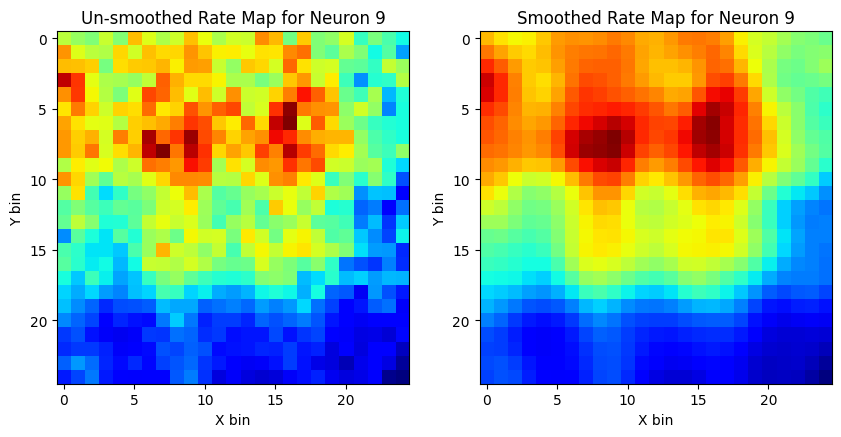

In [9]:
idx = 9

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(rate_maps[idx], cmap='jet')
axs[0].set_title(f'Un-smoothed Rate Map for Neuron {idx}')
axs[0].set_xlabel('X bin')
axs[0].set_ylabel('Y bin')

axs[1].imshow(rate_maps_smooth[idx], cmap='jet')
axs[1].set_title(f'Smoothed Rate Map for Neuron {idx}')
axs[1].set_xlabel('X bin')
axs[1].set_ylabel('Y bin')

plt.show()

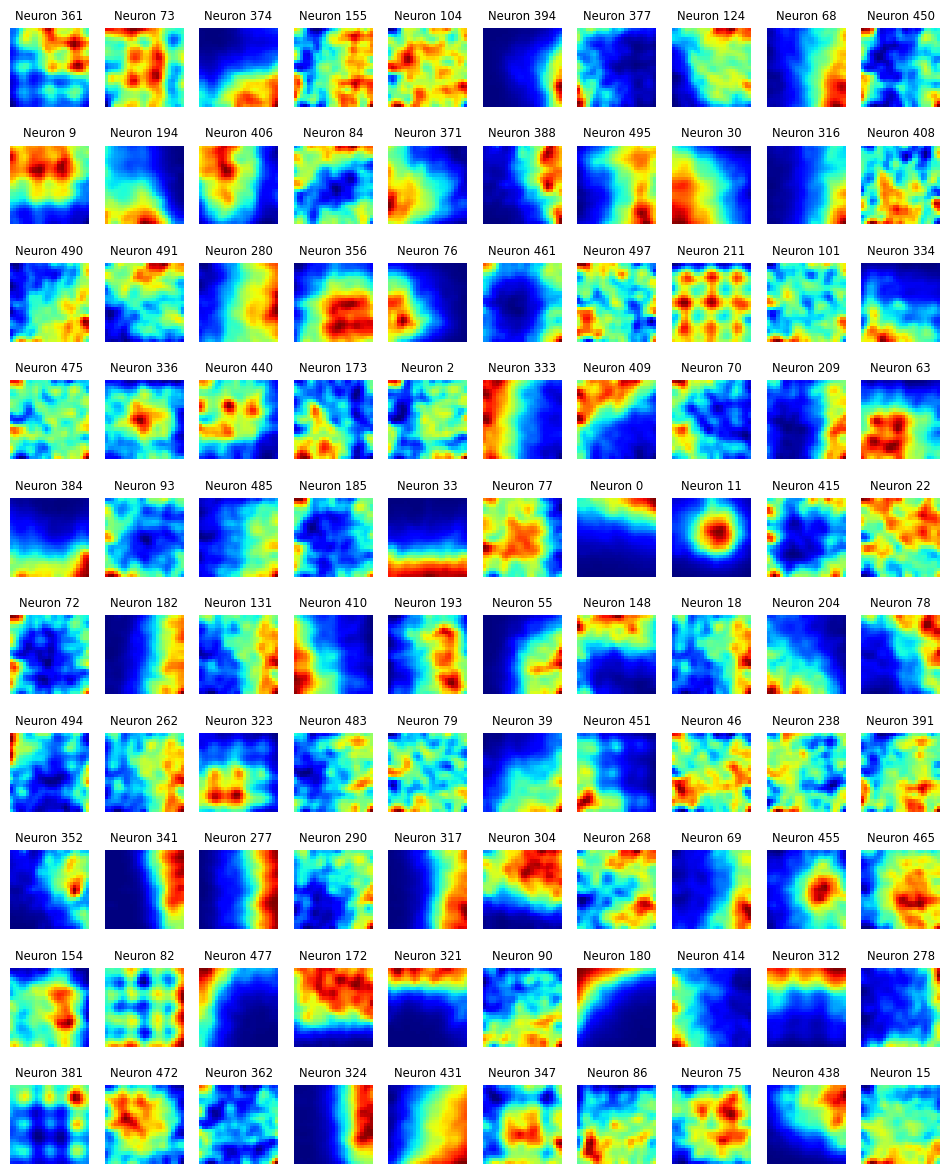

In [10]:
n_plot = 100
indices = np.random.choice(rate_maps_smooth.shape[0], size=n_plot, replace=False)

n_rows = int(np.ceil(n_plot/10))
fig, axs = plt.subplots(n_rows, 10, figsize=(12, n_rows*1.5))

for idx in range(n_plot):
    ax = axs.flat[idx]
    ax.imshow(rate_maps_smooth[indices[idx]], cmap='jet')
    ax.set_title(f'Neuron {indices[idx]}', fontsize='small')
    ax.set_axis_off()

plt.show()

### 4. Polar maps

Comparable to rate maps, the **polar maps** show how a neuron fires when it is tuned to a specific angle in polar space by binnind head direction into angular bins.

The head direction space is divided into $B_\theta = 60$ bins and $P^{(k)} \in \mathbb{R}^{B_\theta}$ is calculated as
$$
P^{(k)}_{i} = \frac{\sum_t A_t^{(k)}~\overrightarrow{1}_{\theta_t \in \text{Bin}_i}}{\sum_t \overrightarrow{1}_{\theta_t \in \text{Bin}_i}}, \quad i \in \{1, \dots, B_\theta\}
$$
Where $A^{(k)}_t$ is the hidden layer’s activity (or value) of unit $k$ and $\theta$ is the agent's head direction.

**Note**: In this notebook, we use the terms _head direction_ and _theta_ interchangeably.

In [11]:
def compute_polar_maps(
    hidden_states:np.array, head_directions:np.array, sigma:float,
    n_bins:int, limits=(-np.pi, np.pi)
):
    """
    Calculates the (smooth) polar map for each neuron based on the given hidden states and thetas.

    Args:
        hidden_states (np.array): (samples, n_hidden) Array of hidden states for each neuron.
        head_directions (np.array): (samples,) Array of head direction points.
        sigma (float, optional): Standard deviation of the circular filter. Defaults to 5.
        n_bins (float): Number of angular bins for the head directions.
        limits (tuple, optional): Limits of the hd space. Defaults to (-np.pi, np.pi).

    Returns:
        polar_maps (np.array): Array of polar maps for each neuron of shape (n_hidden, n_bins).
        occupancy (np.array): Occupancy map of shape (n_bins,).
    """
    
    occupancy = bin_data(head_directions, n_bins=n_bins, limits=limits)
    if sigma > 0:
        occupancy = gaussian_filter(occupancy, sigma, mode='wrap')

    n_cells = hidden_states.shape[1]
    polar_maps = np.empty(shape=(n_cells,occupancy.shape[0]))
    for i in range(n_cells):
        activations = bin_data(
            head_directions, n_bins=n_bins, limits=limits, weights=hidden_states[:,i]
        )
        if sigma > 0: 
            activations = gaussian_filter(activations, sigma, mode='wrap')
        polar_maps[i] = np.divide(
            activations, occupancy, where=occupancy!=0,
            out=np.nan*np.ones_like(activations)
        )

    return polar_maps, occupancy


In [12]:
N_BINS_POLAR = 60
bins_thet = np.linspace(-np.pi, np.pi, N_BINS_POLAR+1)
thetas_ticks = np.array(
    [np.mean([a, b]) for a, b in zip(bins_thet, bins_thet[1:])]
)
bins_thet = bins_thet[:-1]

In [13]:
polar_maps, polar_occupancy = compute_polar_maps(
    hidden_states, head_directions, n_bins=N_BINS_POLAR, sigma=0.
)

polar_maps_smooth, polar_occupancy_smooth = compute_polar_maps(
    hidden_states, head_directions, n_bins=N_BINS_POLAR, sigma=2.5
)

Let's plot the polar map of the same neuron. Note that we will need to use the polar projection.

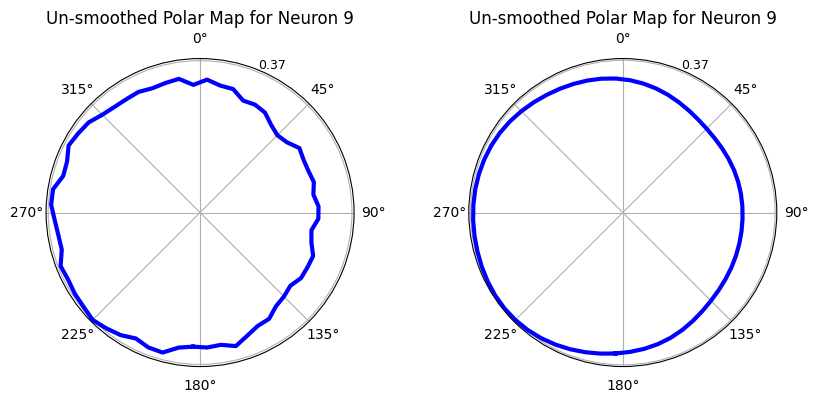

In [14]:
idx = 9

fig, axs = plt.subplots(1, 2, figsize=(10, 4), subplot_kw={'projection': 'polar'})

axs[0].plot(
    np.append(thetas_ticks, thetas_ticks[0]), # we want to close the circle
    np.append(polar_maps[idx], polar_maps[idx][0]), # we want to close the circle
    lw=3, c='blue',
)
# axs[0].set_xticklabels([]) # remove degrees indication
axs[0].set_rticks([max(polar_maps[idx])], labels=[f"{max(polar_maps[idx]):.2f}"]) # add intensity indication
axs[0].tick_params(axis='y', labelsize=9)
axs[0].set_theta_direction(-1)
axs[0].set_theta_zero_location('N') # move 0 to the north
axs[0].grid(True)
axs[0].set_title(f'Un-smoothed Polar Map for Neuron {idx}')

axs[1].plot(
    np.append(thetas_ticks, thetas_ticks[0]), # we want to close the circle
    np.append(polar_maps_smooth[idx], polar_maps_smooth[idx][0]), # we want to close the circle
    lw=3, c='blue',
)
axs[1].set_rticks(
    [max(polar_maps_smooth[idx])],
    labels=[f"{max(polar_maps_smooth[idx]):.2f}"]
) # add intensity indication
axs[1].tick_params(axis='y', labelsize=9)
axs[1].set_theta_direction(-1)
axs[1].set_theta_zero_location('N') # move 0 to the north
axs[1].grid(True)
axs[1].set_title(f'Un-smoothed Polar Map for Neuron {idx}')

plt.show()

### 5. Spatial metrics

In this part we will examine some commonly used metrics used to quantify and classify spatial cells, Following standard neuroscience classification criteria [29, 48]. We quantify spatial and directional selectivity using spatial information (SI) and resultant vector length (RVL), respectively. We compute these metrics on min-max normalised rate and polar maps.

**Spatial information (SI)** measures how much information (in bits) a cell's firing conveys about the agent's position per spike.

Given
- $B \quad\rightarrow$ number of bins

- $R_i \quad\rightarrow$ value of the rate map at bin $i$

- $p_i \quad\rightarrow$ probability of being in bin $i$ (occupancy probability)

- $\hat{R} = \sum_{i=1}^{B} p_i R_i \quad\rightarrow$ overall mean activity

Then
$$
\text{SI} = \sum_{i=1}^{B} p_i \frac{R_i}{\hat{R}} \log_2 \left( \frac{R_i}{\hat{R}} \right)
$$

In [15]:
def spatial_information(rate_map: np.ndarray, occupancy: np.ndarray):
    """
    Calculates the Spatial Information (SI) for a given rate map.

    Args:
        rate_map (np.array): (n_bins, n_bins) Rate map of a single neuron.
        occupancy (np.array): occupancy map of shape (n_bins,).

    Returns:
        si (float): Spatial information content of the rate map.
    """
    # discard bins where occupancy is zero or NaN
    no_occ = np.logical_or(occupancy == 0, np.isnan(occupancy))
    _rate = rate_map[~no_occ]
    _occ = occupancy[~no_occ]

    # calculate total duration and occupancy probability
    duration = np.sum(_occ)
    _occ_prob = _occ / duration

    # calculate mean firing rate
    _rate_mean = np.sum(_rate*_occ) / duration

    mask = _rate > 0
    si = np.sum(
        _occ_prob[mask] * _rate[mask] * np.log2(_rate[mask] / _rate_mean)
    )
    si /= _rate_mean
    
    return si

In [16]:
rate_maps_min = np.moveaxis(
    np.tile(np.nanmin(rate_maps_smooth, axis=(1,2)), (N_BINS, N_BINS, 1)), -1, 0
)
rate_maps_max = np.moveaxis(
    np.tile(np.nanmax(rate_maps_smooth, axis=(1,2)), (N_BINS, N_BINS, 1)), -1, 0
)
rate_maps_norm = np.divide(
    (rate_maps_smooth - rate_maps_min),
    (rate_maps_max - rate_maps_min),
    where=np.logical_and(
        (rate_maps_max - rate_maps_min)!=0,
        ~np.isnan(rate_maps_smooth)
    ),
    out=rate_maps_smooth
)

# uniform_rate_map = np.ones_like(rate_maps_norm[0])/(n**2)
# if occ is None : occ = uniform_rate_map

si = [spatial_information(rm, occupancy_smooth) for rm in rate_maps_norm]

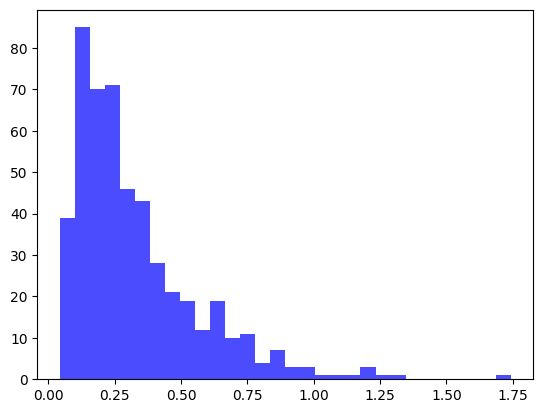

In [17]:
plt.hist(si, bins=30, color='blue', alpha=0.7)
plt.show()

**Kullbeck-Leibler Divergence**

The KL divergence is a distance metric that measures the difference between two distributions.

In spatial cell analysis, it is used to quantify how head-directed a cell is. The polar map (which itself is a distribution on polar coordinate) is compared to a uniform distribution.

KL is a functional of two distributions P and Q:
$$
D_{\mathrm{KL}}(P \,\|\, Q) = \sum_{i=1}^{B} P_i \log_2 \frac{P_i}{Q_i}
$$
Note that this metric tends to 0 if P and Q have the same distribution, and large if they are different.

In [18]:
def compute_kl_divergence(p, q, eps=1e-10):
    '''
    Computes the Kullback-Leibler divergence between two probability distributions.
    '''
    # modified to ensure readability
    p = np.clip(p, eps, None)
    q = np.clip(q, eps, None)
    return np.sum(p * np.log(p / q))

**Resultant vector length (RVL)** measures the concentration of the directional preference.

Given
- $B \quad\rightarrow$ number of bins

- $P_i \quad\rightarrow$ value of the polar map at bin $i$

- $\mathbf{r} = \sum_{i=1}^B \exp\left(j\frac{2\pi}{2B_\theta}~i\right)~P_i \quad\rightarrow$ resultant vector of polar map $P$

Then
$$
\text{RVL} = \frac{|\mathbf{r}|}{\sum_{i=1}^B P_i}
$$

In [19]:
def resultant_vector(polar_map, bins, spacing):
    """
    Calculate the resultant vector of a given set of angles.

    Args:
        polar_map (np.array): (n_bins,) Polar map of a single neuron.
        bins (np.array): Array of angles.
        spacing (float, optional): Known spacing between angles.
    Returns:
        rvl (float): Length of the resultant vector.
        rv_angle (float): Angle of the resultant vector.
    """

    # sum of cos & sin angles
    rv = np.sum(polar_map * np.exp(1j * bins))
    
    # calculate the angle of the resultant vector
    rv_angle = np.angle(rv)

    # get length
    rvl = np.abs(rv) / np.sum(polar_map)

    # for data with known spacing, apply correction factor to correct
    # for bias in the estimation of r
    # (see Biostatistical Analysis, J. H. Zar, p. 601, equ. 26.16)
    rvl *= spacing / 2 / np.sin(spacing / 2)

    return rvl, rv_angle

In [20]:
divisor = np.moveaxis(
    np.tile(polar_maps_smooth.sum(axis=1), (N_BINS_POLAR, 1)), -1, 0
)
polar_maps_norm = np.divide(
    polar_maps_smooth, divisor,
    where=divisor != 0, out=polar_maps_smooth
)

rv_tuple = [
    resultant_vector(
        polar_map=pm,
        bins=bins_thet,
        spacing=2*np.pi/N_BINS_POLAR
    ) for pm in polar_maps_norm
]

rvl = [x[0] for x in rv_tuple]
rvangle = [x[1] for x in rv_tuple]

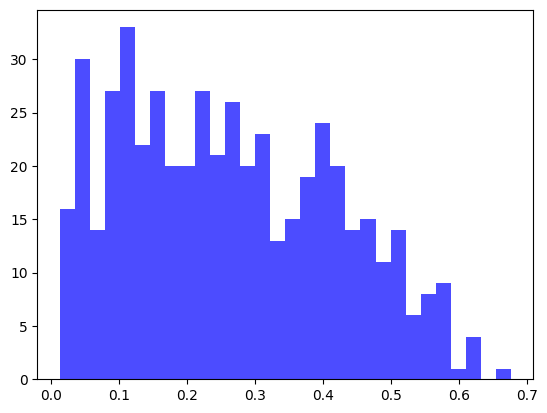

In [21]:
plt.hist(rvl, bins=30, color='blue', alpha=0.7)
plt.show()

### 7. Comparison with *in vivo* Recordings